In [2]:
#preliminary setup
# %pip install -r requirements.txt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler


#Fetching the data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split



# set seeds for reproducibility
random_seed = 302
torch.manual_seed(302); np.random.seed(302)

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=random_seed)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=random_seed, )

Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.86      28.65       5.43        1.1     1421.79        3.13      35.64    -119.58
 std        1.89      12.58       2.41       0.43     1110.97       12.39       2.14       2.01
 min         0.5        1.0       0.85       0.33         6.0        0.69      32.54    -124.35
 max        15.0       52.0     141.91      25.64     35682.0     1243.33      41.95    -114.47


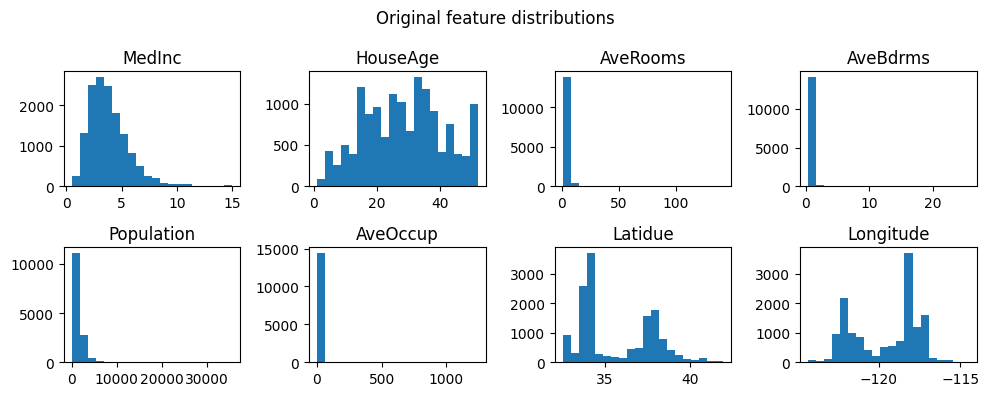

Validation set
size:  (3612, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.89      28.48        5.4       1.09     1431.85        2.93       35.6    -119.54
 std        1.95      12.66       1.82       0.28     1145.46        1.05       2.12       1.98
 min         0.5        1.0       1.38       0.38         3.0        0.75      32.56    -124.25
 max        15.0       52.0      36.48       7.97     15037.0       41.21      41.95    -114.31


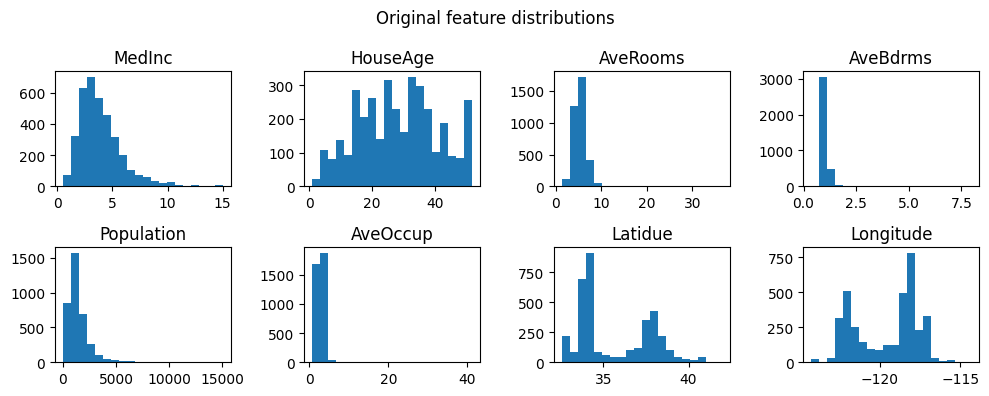

Test set
size:  (2580, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.87      28.77       5.48       1.11     1437.18        2.94      35.62    -119.57
 std         1.9      12.49       3.45        0.8     1228.94        1.29       2.14       1.99
 min         0.5        2.0       0.89        0.5         8.0        1.29      32.55    -124.19
 max        15.0       52.0     132.53      34.07     28566.0        51.4      41.88    -114.49


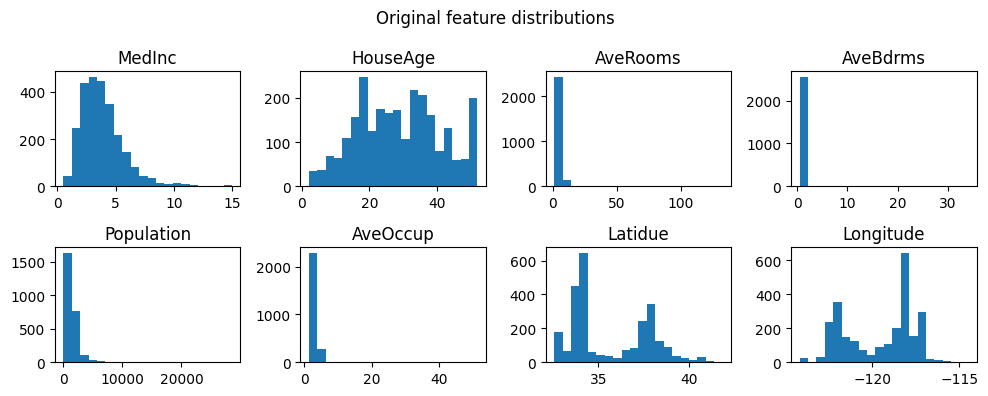

index: 0
index: 2
index: 4
Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        -0.0       -0.0       -0.0       -0.0        -0.0         0.0        0.0       -0.0
 std         1.0        1.0        1.0        1.0         1.0         1.0        1.0        1.0
 min       -1.78       -2.2       -1.9      -1.76       -1.27        -0.2      -1.45      -2.37
 max         5.9       1.86      56.72      56.66       30.84       100.1       2.95       2.54


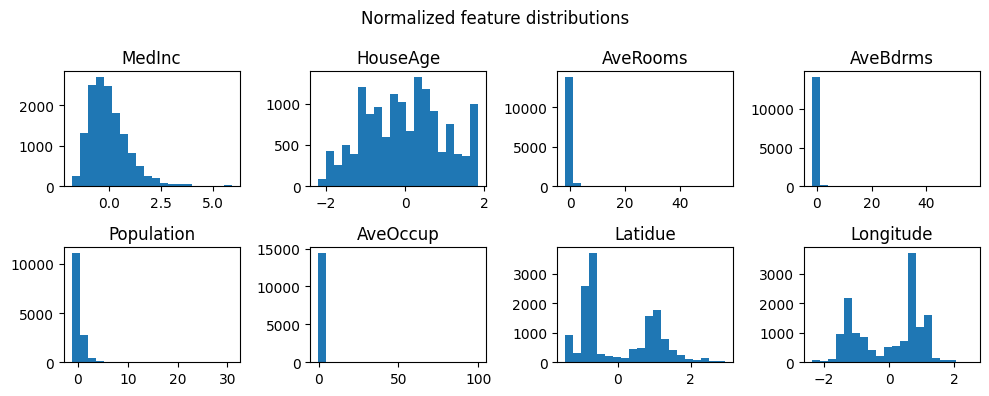

Validation set
size:  (2580, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        0.01       0.01       0.02       0.03        0.01       -0.02      -0.01        0.0
 std        1.01       0.99       1.43       1.84        1.11         0.1        1.0       0.99
 min       -1.78      -2.12      -1.89      -1.38       -1.27       -0.15      -1.45      -2.29
 max         5.9       1.86      52.82      76.13       24.43         3.9       2.92       2.53


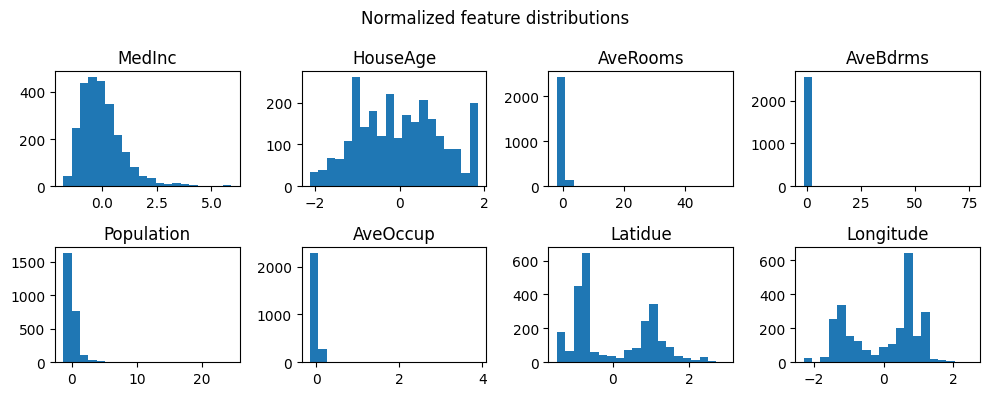

In [3]:
ONLY_TRAINING_SET = False
#a.) Investigating the dataset

all_sets = [X_train,y_train,X_validation,y_validation,X_test,y_test]
all_sets_names = ["Training set","Training targtets","Validation set","Validation targets","Test set","Test targets"]
features = ["MedInc","HouseAge","AveRooms","AveBdrms","Population","AveOccup","Latidue","Longitude"]
if ONLY_TRAINING_SET:
    all_sets = [X_train, y_train]
    all_sets_names = ["Training set","Training targtets"]


#Checking the data, to see what would be good to normalize
for set, name in zip(all_sets[0::2],all_sets_names[0::2]):
    
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
             "std":[],
             "min":[],
             "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))
    
    plt.suptitle("Original feature distributions")
    plt.show()
    fig.savefig(f"./plots/{'feature distributions'}.png")

#Normalizing data

#fitting the scalers first on the training set and then applying same scalings to the validation and test set
normalized_sets = []
standard_dist_scaler_1 = StandardScaler()
standard_dist_scaler_1.fit(X_train)
X_train_standard = standard_dist_scaler_1.transform(X_train)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_standard)
X_train_standart_minmax = min_max_scaler.transform(X_train_standard)

#do another scaling, so it's centered around 0 again
standard_dist_scaler_2 = StandardScaler()
standard_dist_scaler_2.fit(X_train_standart_minmax)

#TODO: Decide normalization on individual level
# now only applied standardization everywhere

for i,set in enumerate(all_sets[0::2]):
    norm_set = standard_dist_scaler_1.transform(set)
    #norm_set = min_max_scaler.transform(norm_set)
    #norm_set = standard_dist_scaler_2.transform(norm_set)
    print(f"index: {i*2}")
    normalized_sets.append(norm_set)

    # new_set = np.zeros_like(set)
    # for col in range(len(features)):

    #     norm_feature = np.reshape(set[:,col],(1,len(set[:,col])))
        
    #     #Standard gauss distribution
    #     norm_feature = (norm_feature-np.mean(norm_feature))/np.std(norm_feature)
    #     all_sets[i*2][:,col] = norm_feature
        
    #     #min-max scaling into -1 +1 range
    #     norm_feature = (norm_feature-np.min(np.abs(norm_feature)))/(np.max(np.abs(norm_feature))-np.min(np.abs(norm_feature)))
    #     new_set[:,col] = norm_feature

    # normalized_sets.append(new_set)

for i,(set,name) in enumerate(zip(normalized_sets[0::2],all_sets_names[0::2])):
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
                "std":[],
                "min":[],
                "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))

    plt.suptitle("Normalized feature distributions")
    plt.show()
    fig.savefig(f"./plots/{'normalized feature distributions'}.png")

## Networks

In [4]:
from models import NeuralNet_deep, NeuralNet_wide, NeuralNet_default, NeuralNet_deep_wider, NeuralNet_deeper_wide

def train_model(model, train_loader, val_loader=None, device='cpu', optimizer=None, num_epochs=30, scheduler=None):
    torch.manual_seed(302); np.random.seed(302)
    loss_fn = nn.MSELoss()
    #saves losses on every batch
    train_losses_all = []
    val_losses_all = []
    model.to(device)
    for epoch in range(num_epochs):
        train_losses_epoch = []
        print('-'*20, f'Epoch {epoch}', '-'*20)
        # Train one epoch
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            if optimizer is not None:
                optimizer.zero_grad()
            predict = model(data)
            loss = loss_fn(predict, target)
            loss.backward()
            if optimizer is not None:
                optimizer.step()

            train_losses_epoch.append(loss.item())
        if scheduler is not None:
            scheduler.step() # update learning rate based on the schedule
        train_loss_epoch_mean =np.mean(train_losses_epoch)
        train_losses_all.append(train_loss_epoch_mean)
        print(f'Average Training Loss for epoch(over all batches) {np.mean(train_losses_epoch)}')
        

        # correct = 0
        if val_loader is not None:
            # Evaluate on validation set
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    predict = model(data)
                    val_loss += F.mse_loss(predict, target, reduction='sum').item()  # sum up batch loss
                    # correct += (predict == target).sum().item()

            val_loss /= len(val_loader.dataset)
            # avg_correct = correct / len(val_loader.dataset)
            val_losses_all.append(val_loss)
            # val_accuracies.append(avg_correct)

            print(f'Validation loss for epoch: {val_loss:.4f})\n')
    
    return train_losses_all, val_losses_all


In [5]:
#evaluation of the different models
from torch.utils.data import TensorDataset, DataLoader

X_train_norm = normalized_sets[0]
X_val_norm = normalized_sets[1]
X_test_norm = normalized_sets[2]

random_seed = 302
torch.manual_seed(302); np.random.seed(302)

X_train_torch = torch.tensor(X_train_norm,dtype=torch.float32)
y_train_torch = torch.tensor(y_train.reshape((len(y_train),1)),dtype=torch.float32)
X_validation_torch = torch.tensor(X_val_norm,dtype=torch.float32)
y_validation_torch = torch.tensor(y_validation.reshape((len(y_validation),1)),dtype=torch.float32)
X_test_torch = torch.tensor(X_test_norm,dtype=torch.float32)
y_test_torch = torch.tensor(y_test.reshape((len(y_test),1)),dtype=torch.float32)

train_dataset = TensorDataset(X_train_torch,y_train_torch)
validation_dataset = TensorDataset(X_validation_torch,y_validation_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu' # if you have a gpu, you can move the model onto it like this
all_models = NeuralNet_deep(), NeuralNet_wide(), NeuralNet_default(), NeuralNet_deep_wider(), NeuralNet_deeper_wide()

best_loss = 100
for model in all_models:
    print(model._get_name())
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss, val_loss = train_model(model,train_loader,val_loader,device, optimizer=optimizer, num_epochs=30)

    if np.min(val_loss) < best_loss:
        best_model = model
        best_epoch = np.argmin(val_loss)
        best_loss = np.min(val_loss)

    fig,axs = plt.subplots(1,2,layout="tight")
    axs[0].plot(train_loss)
    axs[0].set_title("training loss")
    # axs[0].set_ylim([max(train_loss),max(train_loss)])
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("MSE loss")
    
    axs[1].plot(val_loss)
    axs[1].set_title("validation loss")
    # axs[1].set_ylim([max(val_loss),max(val_loss)])
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("MSE loss")
    plt.suptitle(f"{model._get_name()}")
    plt.show()

print(f"best model: {best_model._get_name()}, best epoch: {best_epoch}, best validation loss: {best_loss}")

NeuralNet_deep
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7094007885594548
Validation loss for epoch: 0.4209)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3750180830700999
Validation loss for epoch: 0.3771)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.349710059475846
Validation loss for epoch: 0.3454)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3258181413783964
Validation loss for epoch: 0.3338)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31532383380474244
Validation loss for epoch: 0.3259)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29972969422496
Validation loss for epoch: 0.3240)

-------------------- Epoch 6 --------------------
Average

KeyboardInterrupt: 

## c) Optimizers and Scheduling

Optimizer: SGD with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.468844077096576
Validation loss for epoch: 1.1848)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.9563000951852418
Validation loss for epoch: 0.8098)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.7014009858918401
Validation loss for epoch: 0.6681)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.6287258914877883
Validation loss for epoch: 0.6318)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5988203682401011
Validation loss for epoch: 0.6065)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5722866538021945
Validation loss for epoch: 0.5826)

------

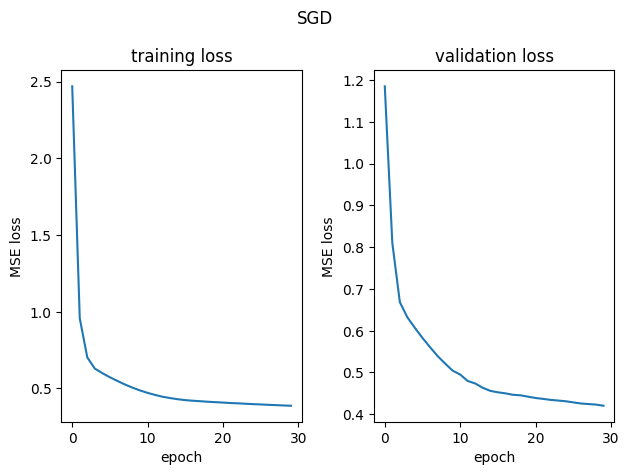

Optimizer: SGD with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.21020308638041
Validation loss for epoch: 1.1245)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.8935126792144986
Validation loss for epoch: 0.7645)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6879227394155697
Validation loss for epoch: 0.6676)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.6325592392709403
Validation loss for epoch: 0.6298)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5968093398991412
Validation loss for epoch: 0.5982)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5726582687512963
Validation loss for epoch: 0.5838)

--

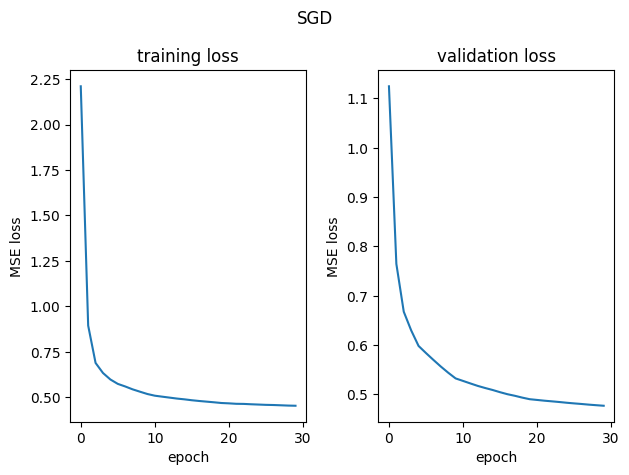

Optimizer: SGD with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.304737050844505
Validation loss for epoch: 1.0927)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.868461463963036
Validation loss for epoch: 0.7226)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6540049079772645
Validation loss for epoch: 0.6399)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.6076776678715132
Validation loss for epoch: 0.6115)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5806106860724698
Validation loss for epoch: 0.5880)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5569162069762175
Validation loss for epoch: 0.570

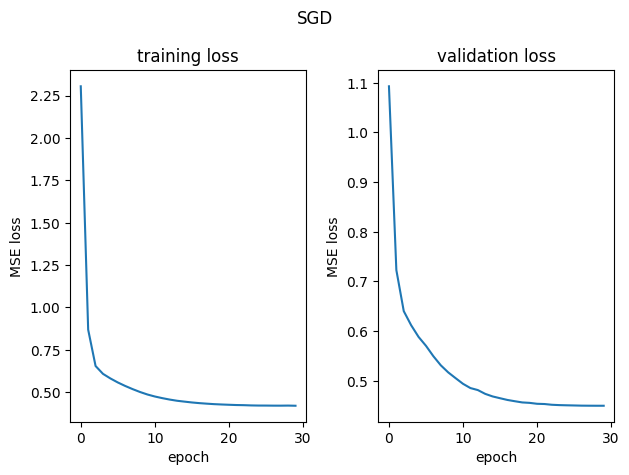

Optimizer: SGD with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.253671924097348
Validation loss for epoch: 0.8849)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.7021793005081405
Validation loss for epoch: 0.6359)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.5979913829174717
Validation loss for epoch: 0.6023)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.5727057367299511
Validation loss for epoch: 0.5849)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5563265288298109
Validation loss for epoch: 0.5710)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.54218051767191
Validation loss for epo

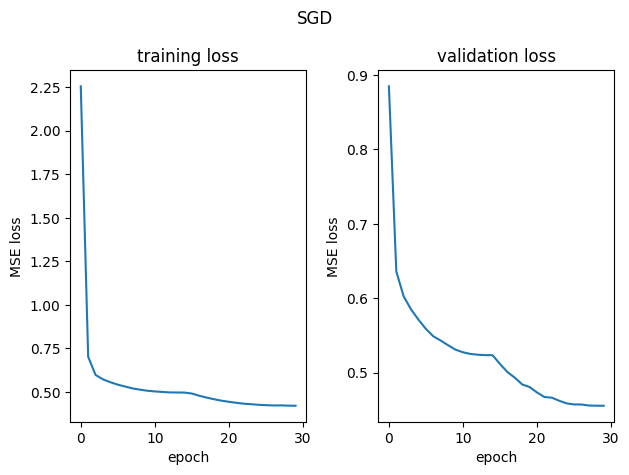

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9306406030942381
Validation loss for epoch: 0.5225)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.459085749379829
Validation loss for epoch: 0.4498)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41247050256460116
Validation loss for epoch: 0.4286)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38273981399834156
Validation loss for epoch: 0.4044)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.36904038098203923
Validation loss for epoch: 0.3934)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3487891219061824
Validation loss for epoch

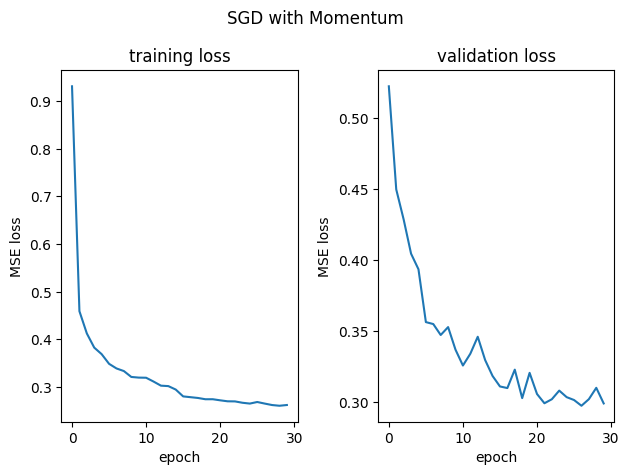

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9818111214687867
Validation loss for epoch: 0.5423)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4596318521133039
Validation loss for epoch: 0.4464)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4105631047612534
Validation loss for epoch: 0.4543)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38372275610742845
Validation loss for epoch: 0.4087)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.36783947709914855
Validation loss for epoch: 0.3784)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3498068814520287
Validation loss for 

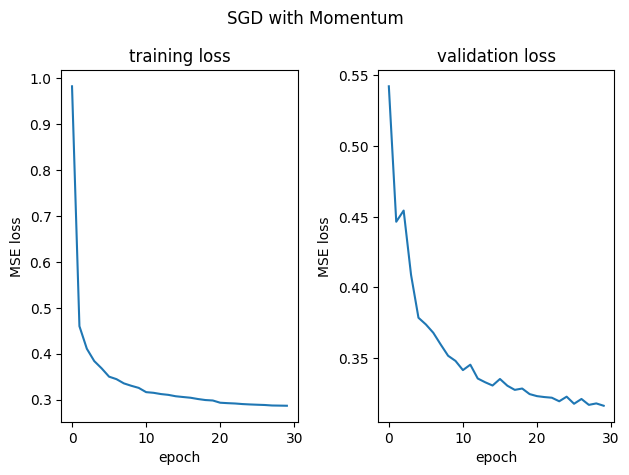

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9065323584770735
Validation loss for epoch: 0.5153)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.455897145451302
Validation loss for epoch: 0.4598)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41333903866795313
Validation loss for epoch: 0.4455)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3890838051396134
Validation loss for epoch: 0.4098)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37205888283134037
Validation loss for epoch: 0.3823)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35909837161281466
Validation los

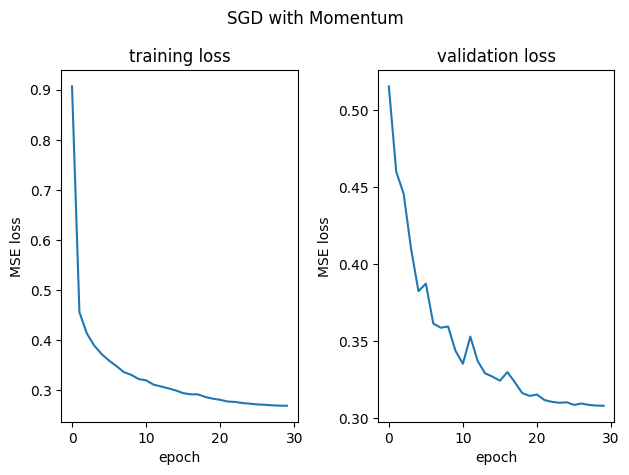

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.023592351812177
Validation loss for epoch: 0.5893)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4926919895265482
Validation loss for epoch: 0.4717)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41466295396068453
Validation loss for epoch: 0.4178)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.382115428162887
Validation loss for epoch: 0.3974)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.365134717088885
Validation loss for epoch: 0.3848)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35045031768030827
Validat

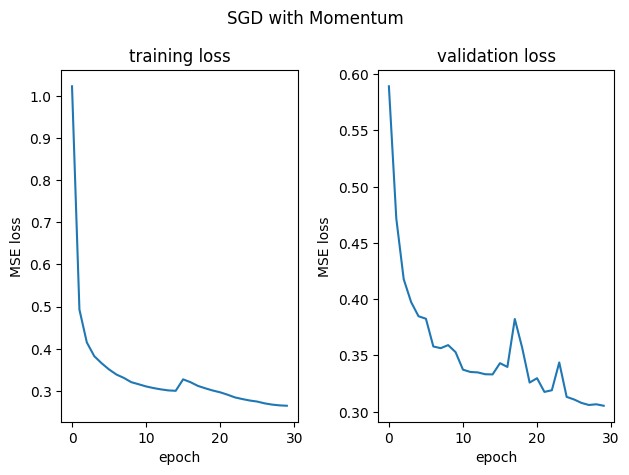

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.885217633691773
Validation loss for epoch: 0.5123)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4514647160813344
Validation loss for epoch: 0.4506)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40756404121299233
Validation loss for epoch: 0.4209)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3828267216253861
Validation loss for epoch: 0.4159)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.369097172884287
Validation loss for epoch: 0.3885)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3527953923572745
Validation loss for

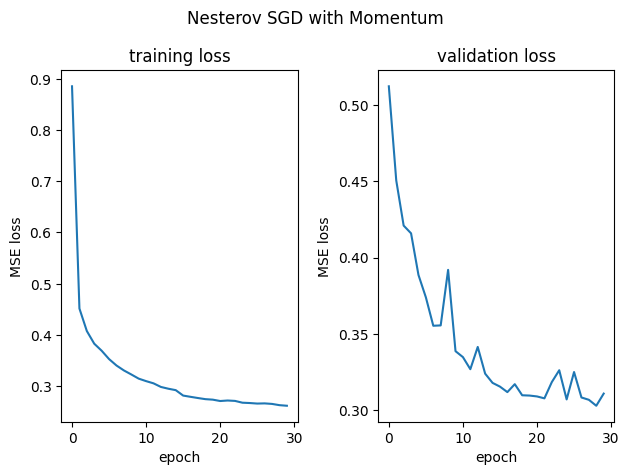

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8657889053291452
Validation loss for epoch: 0.5256)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4574763354540399
Validation loss for epoch: 0.4548)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4018175464980634
Validation loss for epoch: 0.4122)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3738701831780176
Validation loss for epoch: 0.3986)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.35476039648385704
Validation loss for epoch: 0.3870)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3392337171641071
Validation l

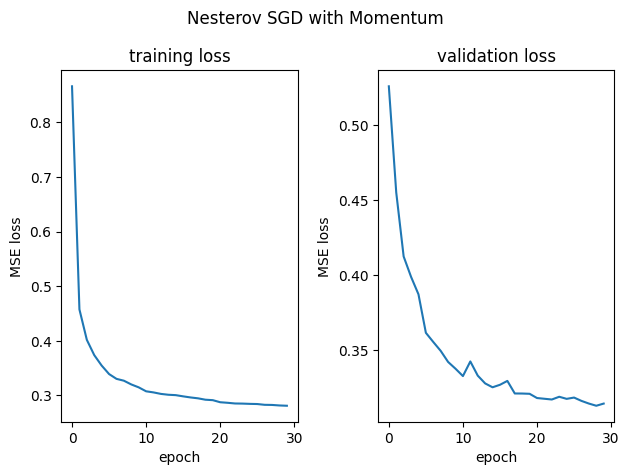

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9348695666850668
Validation loss for epoch: 0.5243)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4574761852556098
Validation loss for epoch: 0.4507)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40917624945266057
Validation loss for epoch: 0.4207)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38450303794074375
Validation loss for epoch: 0.4092)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.36637507379055023
Validation loss for epoch: 0.4020)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3534565076759431
Vali

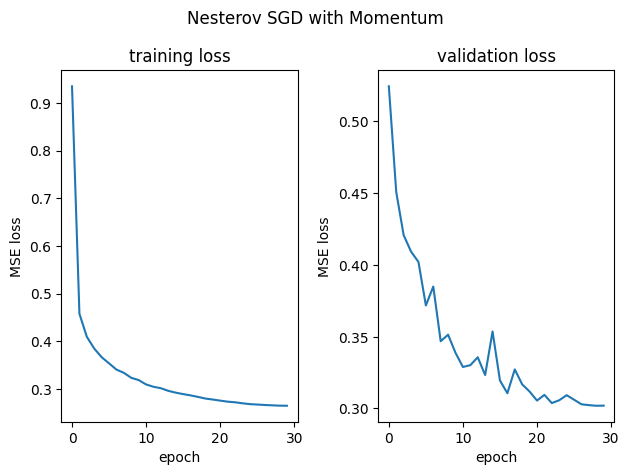

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9887104151457284
Validation loss for epoch: 0.5201)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.44289088684373196
Validation loss for epoch: 0.4432)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4007886360869207
Validation loss for epoch: 0.4141)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.37750208822894943
Validation loss for epoch: 0.4016)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3616274969108337
Validation loss for epoch: 0.3817)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.350486079593

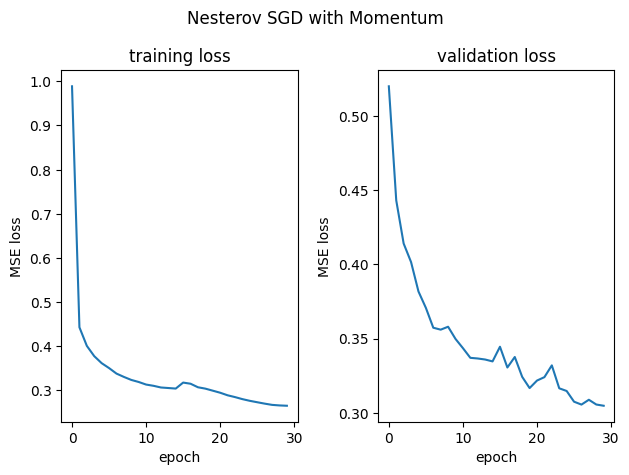

Optimizer: RMSProp with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6123987502888241
Validation loss for epoch: 0.4099)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.40435286937693576
Validation loss for epoch: 0.5185)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3747821311111999
Validation loss for epoch: 0.3545)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34516680522500415
Validation loss for epoch: 0.3466)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3295476683209428
Validation loss for epoch: 0.4372)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3176286518738597
Validation loss for epoch: 0.4535)


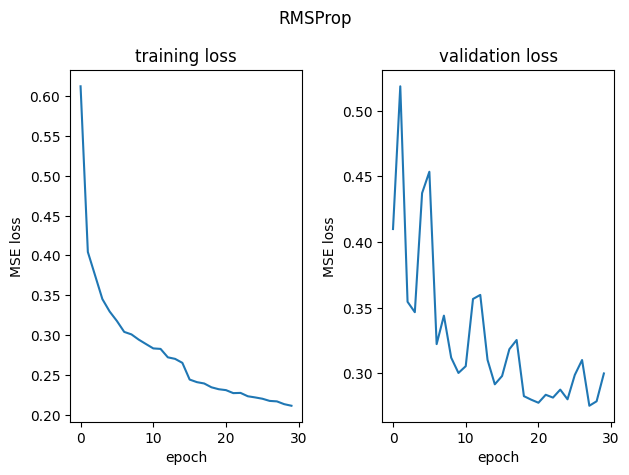

Optimizer: RMSProp with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6027699966412202
Validation loss for epoch: 0.4994)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.404456677986721
Validation loss for epoch: 0.3867)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3589808620776223
Validation loss for epoch: 0.5044)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33999976319615294
Validation loss for epoch: 0.3275)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31507674670588653
Validation loss for epoch: 0.3158)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2853571476365349
Validation loss for epoch: 0.30

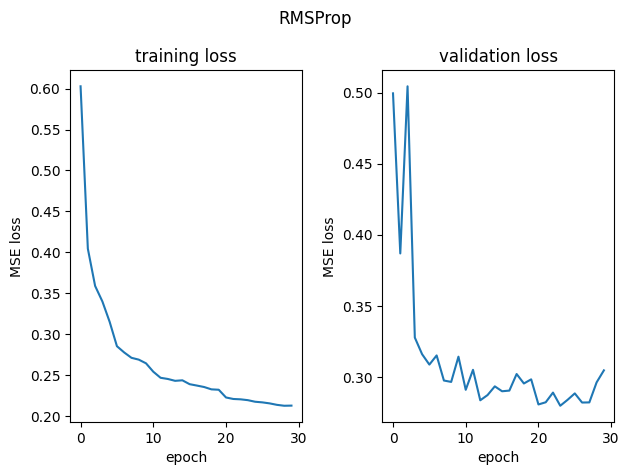

Optimizer: RMSProp with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7124823566064634
Validation loss for epoch: 0.3927)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4076503859750465
Validation loss for epoch: 0.3934)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37049001740473037
Validation loss for epoch: 0.3507)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34385886811445243
Validation loss for epoch: 0.3808)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3224104953418791
Validation loss for epoch: 0.3227)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3082894140656675
Validation loss for epoc

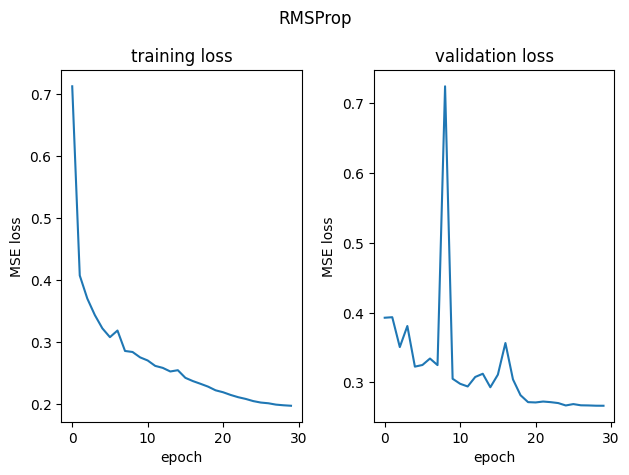

Optimizer: RMSProp with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5396750393958218
Validation loss for epoch: 0.8515)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3957559167184925
Validation loss for epoch: 0.3850)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35954709171391697
Validation loss for epoch: 0.4443)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33105552636614416
Validation loss for epoch: 0.3441)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31567734097484995
Validation loss for epoch: 0.3285)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.298796463535225
Validation los

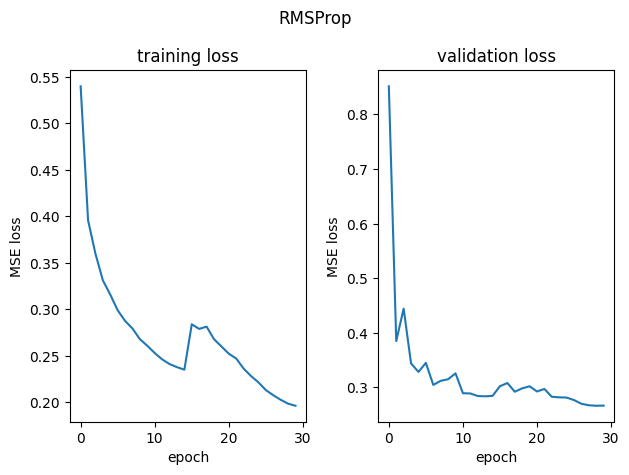

Optimizer: Adam with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8141481096534866
Validation loss for epoch: 0.4086)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38005965953049936
Validation loss for epoch: 0.3758)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3512804802276392
Validation loss for epoch: 0.3805)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3319113743285426
Validation loss for epoch: 0.3332)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32584661728315123
Validation loss for epoch: 0.3357)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3114030198317713
Validation loss for epoch: 0.3296)

--

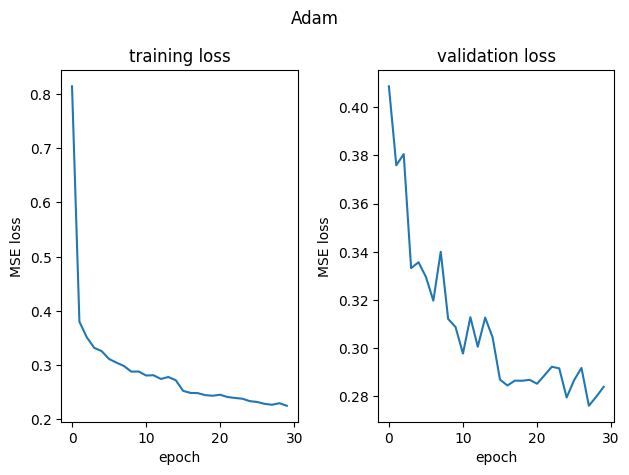

Optimizer: Adam with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6239974438418857
Validation loss for epoch: 0.4631)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4042470927754071
Validation loss for epoch: 0.3727)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3493703377919387
Validation loss for epoch: 0.3655)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33449605176538494
Validation loss for epoch: 0.3560)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3168537313431765
Validation loss for epoch: 0.3393)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29479468430895195
Validation loss for epoch: 0.3182

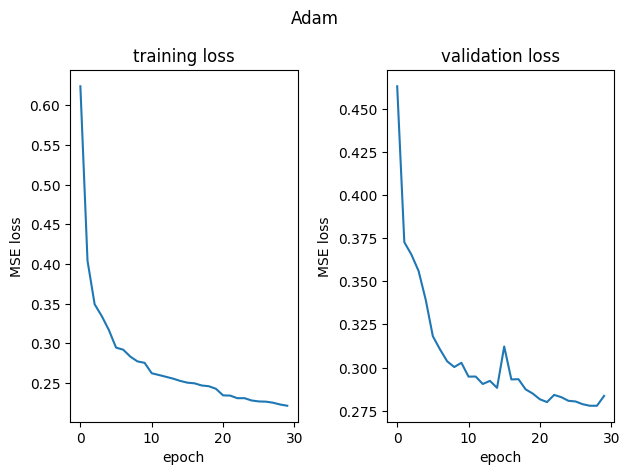

Optimizer: Adam with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6125079112836217
Validation loss for epoch: 0.4038)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3699307801383259
Validation loss for epoch: 0.3555)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3429055466291915
Validation loss for epoch: 0.3463)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3193103518600749
Validation loss for epoch: 0.3304)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3348596625491581
Validation loss for epoch: 0.3306)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30952429133508585
Validation loss for epoch: 0

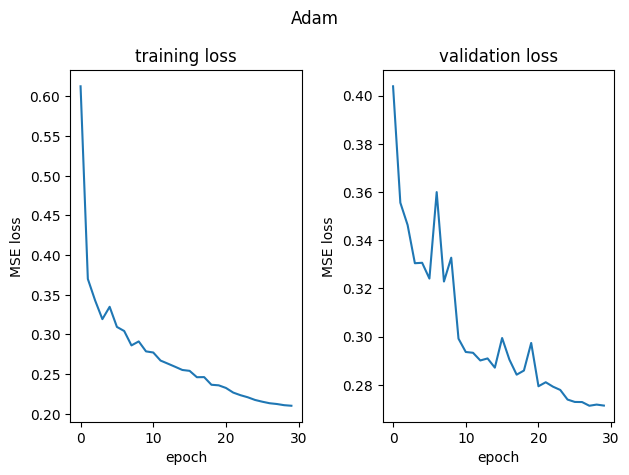

Optimizer: Adam with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7066197748403106
Validation loss for epoch: 0.4212)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.36625474732599955
Validation loss for epoch: 0.4110)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3380572273503099
Validation loss for epoch: 0.3488)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.32399406003872905
Validation loss for epoch: 0.3431)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3126963223371885
Validation loss for epoch: 0.3609)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2976785870681031
Validation loss f

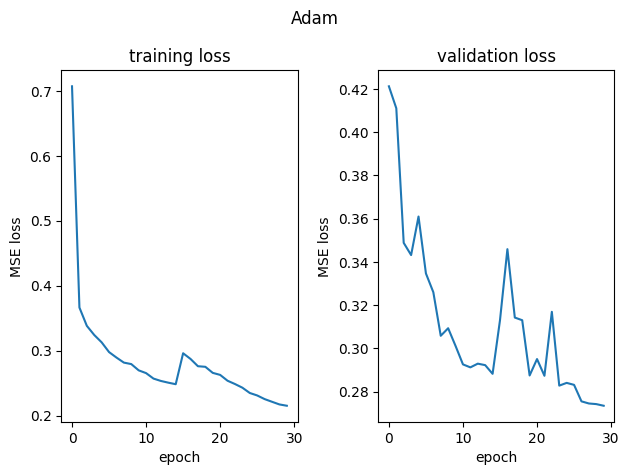

Optimizer: SGD with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.054418581315374
Validation loss for epoch: 0.5791)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.5128190007753077
Validation loss for epoch: 0.4906)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.44933043525809735
Validation loss for epoch: 0.4560)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4204195917180154
Validation loss for epoch: 0.4348)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3996382100194429
Validation loss for epoch: 0.4228)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3849918203247068
Validation loss for epoch: 0.4640)

-----

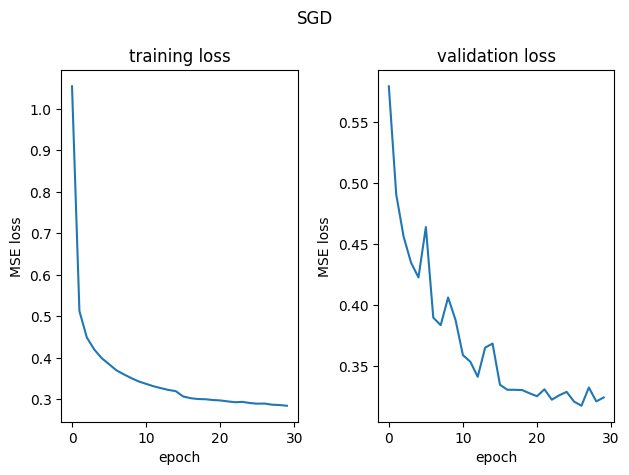

Optimizer: SGD with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.0274123414295964
Validation loss for epoch: 0.6070)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.5322175230666072
Validation loss for epoch: 0.5159)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4516723295756146
Validation loss for epoch: 0.4560)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4167883542193248
Validation loss for epoch: 0.4394)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.39874979560222246
Validation loss for epoch: 0.4251)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3828299894467392
Validation loss for epoch: 0.4105)


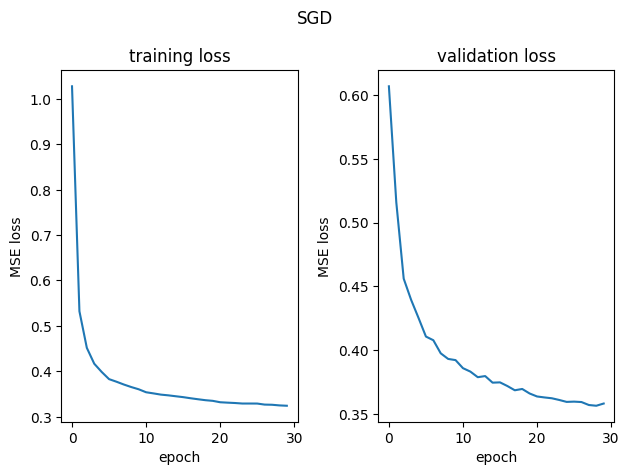

Optimizer: SGD with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.1298410099296443
Validation loss for epoch: 0.5790)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.5079911268785992
Validation loss for epoch: 0.4963)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.44768728142752584
Validation loss for epoch: 0.4581)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.41735348692246244
Validation loss for epoch: 0.4399)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.398220904880261
Validation loss for epoch: 0.4417)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3841962428285485
Validation loss for epoch: 0.

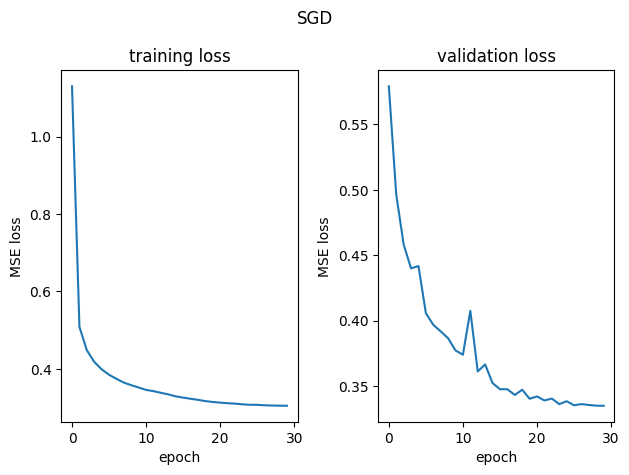

Optimizer: SGD with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.0476476789773566
Validation loss for epoch: 0.5435)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4782621288853409
Validation loss for epoch: 0.4700)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4265068579893724
Validation loss for epoch: 0.4657)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.40456368850000135
Validation loss for epoch: 0.4282)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.388608810566036
Validation loss for epoch: 0.4159)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3784669507294893
Validation loss for 

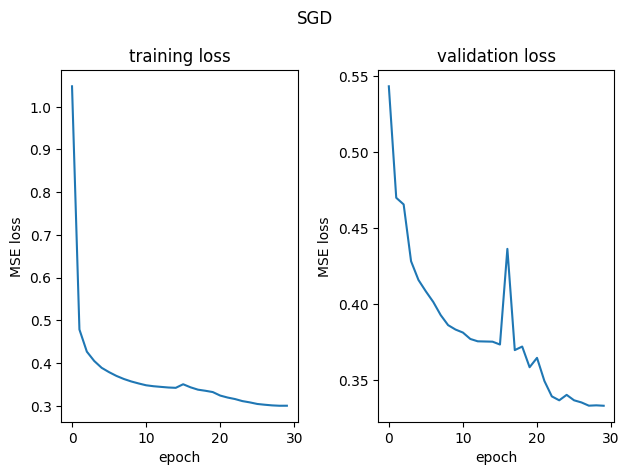

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6511828334985581
Validation loss for epoch: 0.4499)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39663870873308815
Validation loss for epoch: 0.4334)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3772180454920879
Validation loss for epoch: 0.3678)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3654693979769945
Validation loss for epoch: 0.3724)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3375301936031443
Validation loss for epoch: 0.3512)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.32207024877116214
Validation loss for epoch

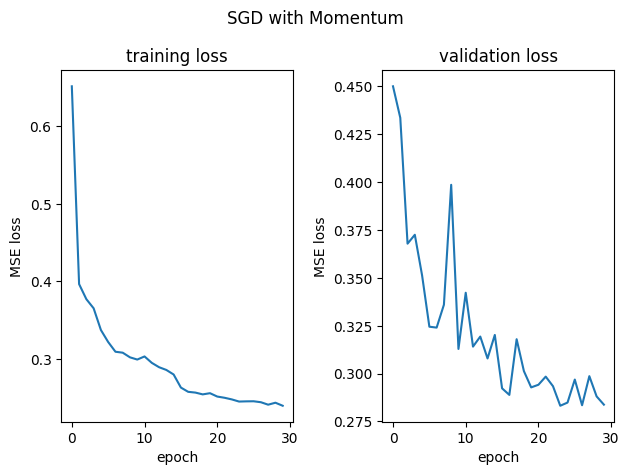

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6158916046430843
Validation loss for epoch: 0.4954)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3951959475149623
Validation loss for epoch: 0.3992)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37640231369739086
Validation loss for epoch: 0.3699)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3435048432938293
Validation loss for epoch: 0.3656)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33440305112935276
Validation loss for epoch: 0.3328)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3018923281832079
Validation loss for 

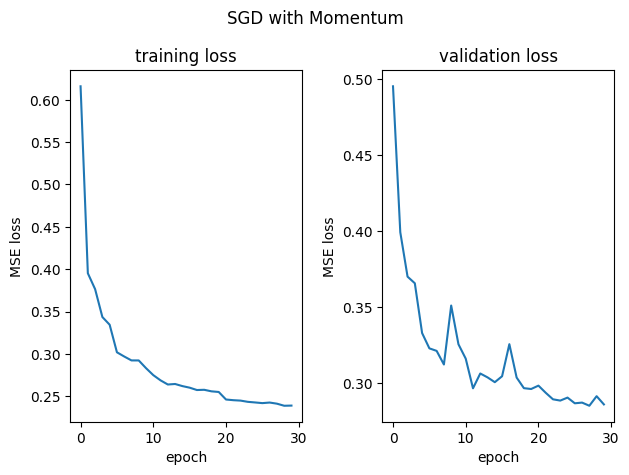

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6487265824612263
Validation loss for epoch: 0.4435)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.40241170684452604
Validation loss for epoch: 0.4095)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37787345773746484
Validation loss for epoch: 0.3916)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.35569477129101224
Validation loss for epoch: 0.3726)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.34128994756765596
Validation loss for epoch: 0.3480)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.32269224211309866
Validation 

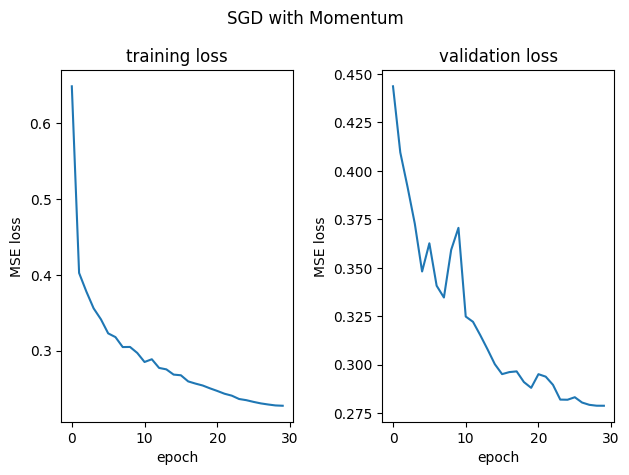

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6584422354611148
Validation loss for epoch: 0.5259)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3963223226961836
Validation loss for epoch: 0.4090)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.36938588898134445
Validation loss for epoch: 0.3596)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3516858315045855
Validation loss for epoch: 0.3786)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33244200980505056
Validation loss for epoch: 0.3595)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3164849059936483
Vali

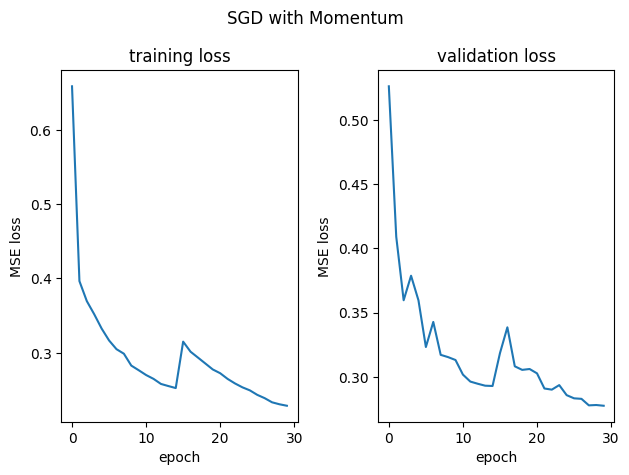

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5841615499054964
Validation loss for epoch: 0.4440)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3828521267535676
Validation loss for epoch: 0.4176)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35361311970426973
Validation loss for epoch: 0.3743)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33664417715199224
Validation loss for epoch: 0.3607)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32270269760186165
Validation loss for epoch: 0.3525)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31490591112359434
Validation los

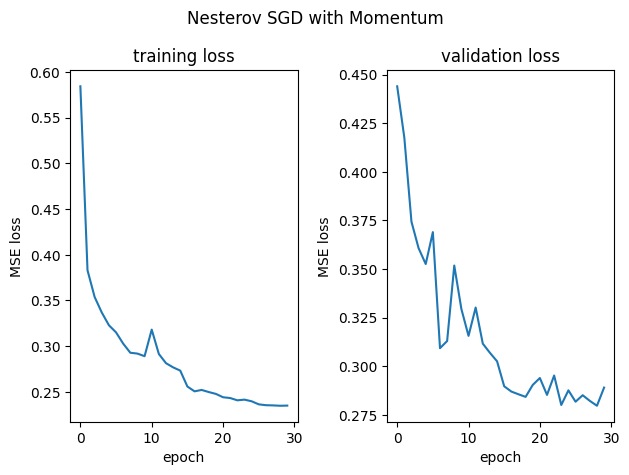

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6206361985707705
Validation loss for epoch: 0.4328)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.380400607345906
Validation loss for epoch: 0.4005)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3526873931255752
Validation loss for epoch: 0.3601)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3310964693175217
Validation loss for epoch: 0.4300)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3164609863991495
Validation loss for epoch: 0.3238)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29387002390504413
Validation lo

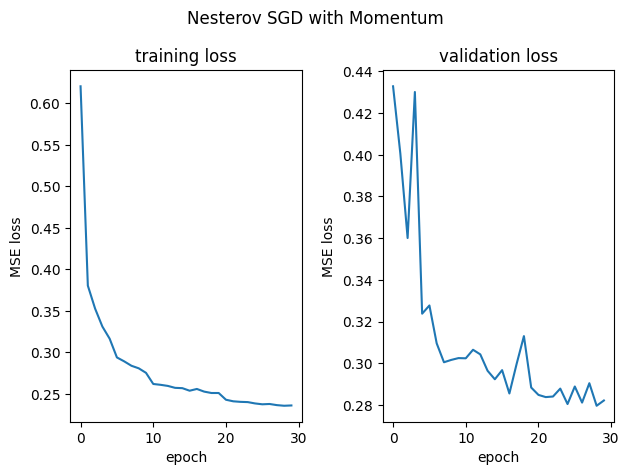

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6172636965273228
Validation loss for epoch: 0.4199)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3839941117418023
Validation loss for epoch: 0.4026)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35904322284380946
Validation loss for epoch: 0.3628)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3344402751366122
Validation loss for epoch: 0.3412)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32388964321761005
Validation loss for epoch: 0.3256)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3108310495560939
Valid

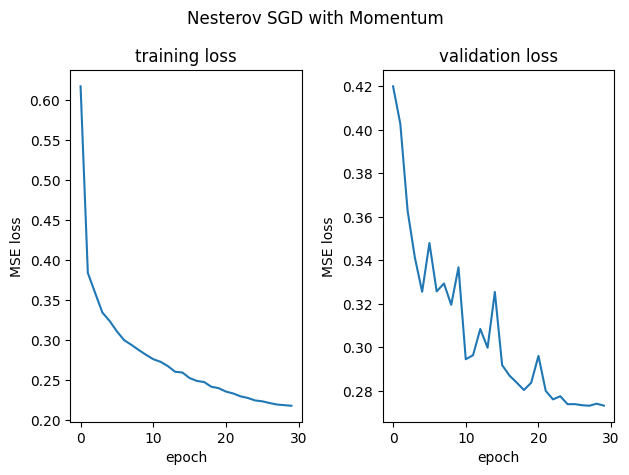

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6204244178612676
Validation loss for epoch: 0.4577)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39204046911502305
Validation loss for epoch: 0.4367)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3587625322088731
Validation loss for epoch: 0.3940)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3352260681907688
Validation loss for epoch: 0.3435)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3171464844186485
Validation loss for epoch: 0.3250)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3031806880196

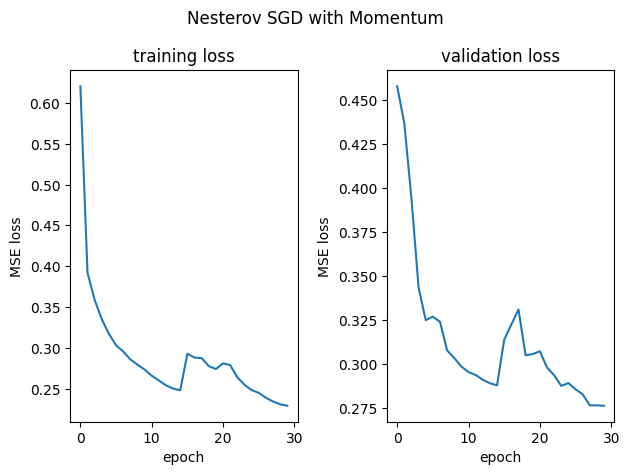

Optimizer: RMSProp with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 8.666873679570523
Validation loss for epoch: 0.4826)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.43771308340725645
Validation loss for epoch: 0.3877)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.39611550682611696
Validation loss for epoch: 0.3532)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3647395742282403
Validation loss for epoch: 0.4198)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.34448462978532884
Validation loss for epoch: 0.3409)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.32764474012419187
Validation loss for epoch: 0.3367)

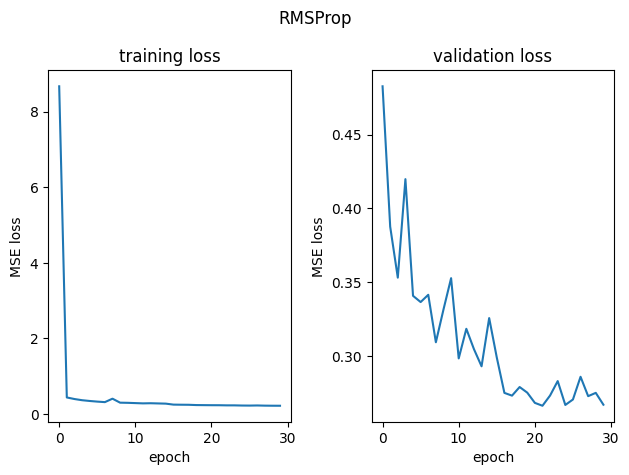

Optimizer: RMSProp with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 10.442185216377267
Validation loss for epoch: 0.4109)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.41645082059950955
Validation loss for epoch: 0.6855)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4058321974182551
Validation loss for epoch: 0.5723)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39377951038490355
Validation loss for epoch: 0.3547)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.34711377034211055
Validation loss for epoch: 0.3352)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29932167662917514
Validation loss for epoch: 0

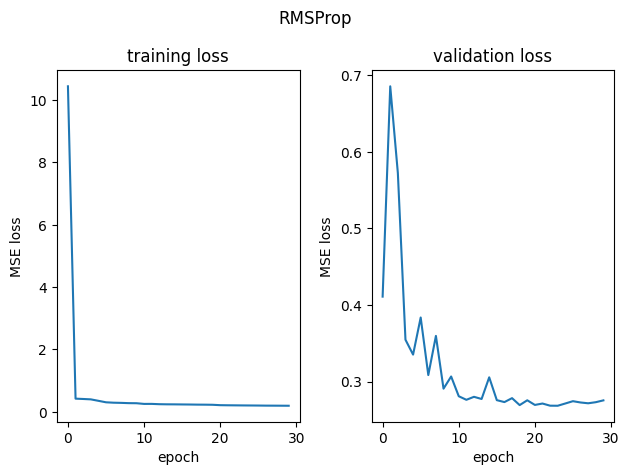

Optimizer: RMSProp with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 5.951345040833792
Validation loss for epoch: 0.4210)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.43290119753342815
Validation loss for epoch: 0.4784)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.38609585398396035
Validation loss for epoch: 0.4235)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.35403134902955685
Validation loss for epoch: 0.3595)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3300946109425441
Validation loss for epoch: 0.4982)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.32000378949518227
Validation loss for epo

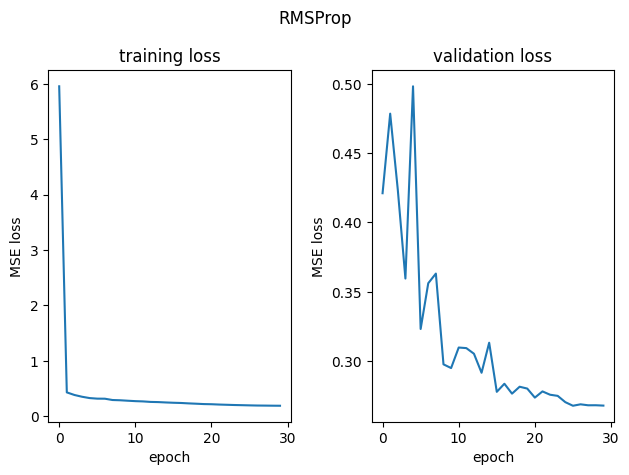

Optimizer: RMSProp with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 10.703424523296082
Validation loss for epoch: 0.5607)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4322168728814716
Validation loss for epoch: 0.3778)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4370517134171935
Validation loss for epoch: 0.3608)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.356958937394408
Validation loss for epoch: 0.3973)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32937743048290763
Validation loss for epoch: 0.3272)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3111275529769142
Validation loss 

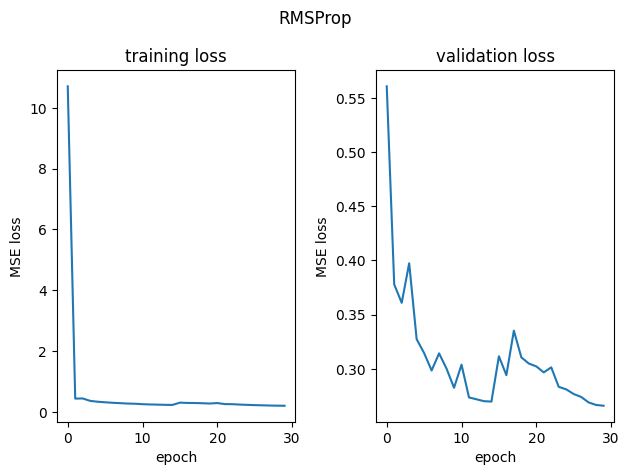

Optimizer: Adam with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5592618676940951
Validation loss for epoch: 0.3842)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3752748472039151
Validation loss for epoch: 0.3605)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3506404041782417
Validation loss for epoch: 0.3623)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3745709546569702
Validation loss for epoch: 0.3903)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31998987826395087
Validation loss for epoch: 0.3280)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30919541964159075
Validation loss for epoch: 0.3211)

--

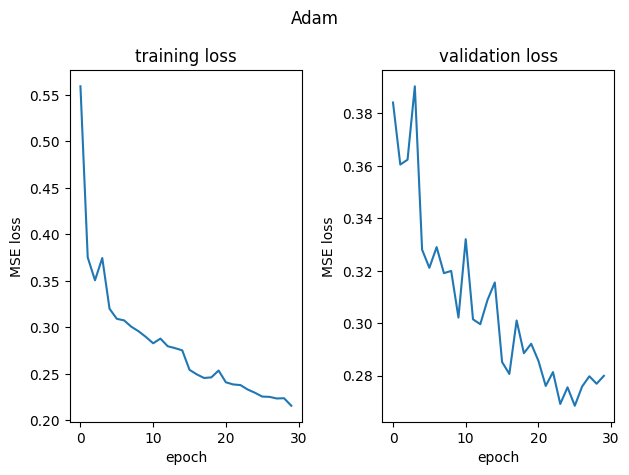

Optimizer: Adam with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5420386833592062
Validation loss for epoch: 0.3941)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3963563752945809
Validation loss for epoch: 0.4620)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3497089795537491
Validation loss for epoch: 0.3570)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33765834172676623
Validation loss for epoch: 0.3419)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33056284861424856
Validation loss for epoch: 0.3561)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29700489363641336
Validation loss for epoch: 0.315

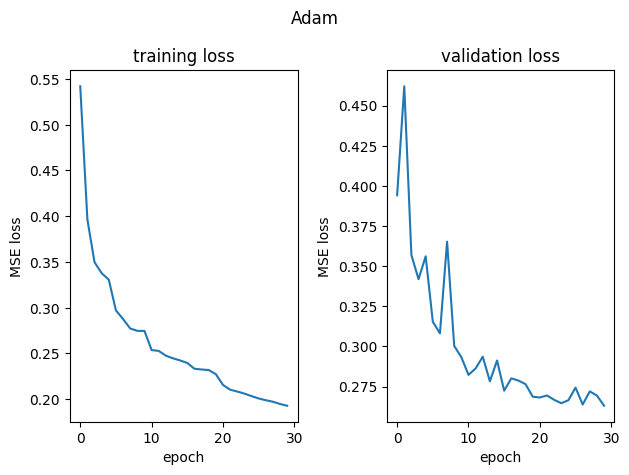

Optimizer: Adam with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5398007597180858
Validation loss for epoch: 0.4260)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4461802957925649
Validation loss for epoch: 0.3512)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.33804213684217066
Validation loss for epoch: 0.3417)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3250933126175562
Validation loss for epoch: 0.3162)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32909736094946884
Validation loss for epoch: 0.3578)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30870649889441193
Validation loss for epoch:

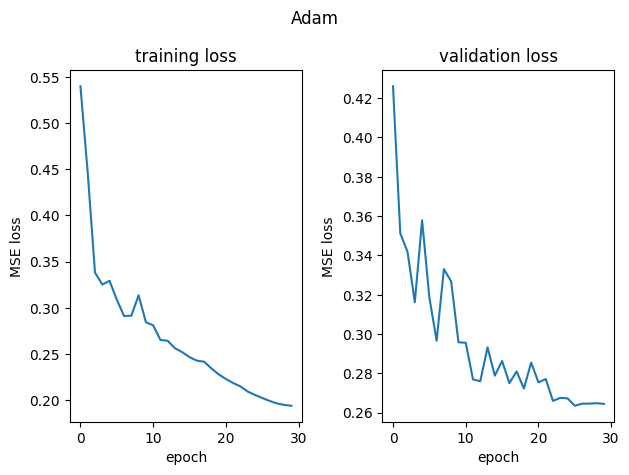

Optimizer: Adam with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5279952893116041
Validation loss for epoch: 0.3759)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3736506601284563
Validation loss for epoch: 0.3558)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.36858083495655947
Validation loss for epoch: 0.3815)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.338631682130879
Validation loss for epoch: 0.3997)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32789919378680993
Validation loss for epoch: 0.3383)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30480485846313227
Validation loss f

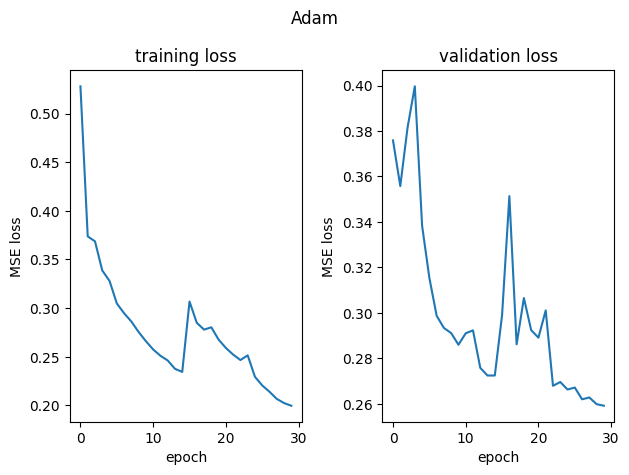

Optimizer: SGD with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8636991327908714
Validation loss for epoch: 0.5126)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4345118108708247
Validation loss for epoch: 0.4408)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.39038929089376356
Validation loss for epoch: 0.4201)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3719474271731039
Validation loss for epoch: 0.4921)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.357277605979316
Validation loss for epoch: 0.3866)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3483665693979875
Validation loss for epoch: 0.3556)

------

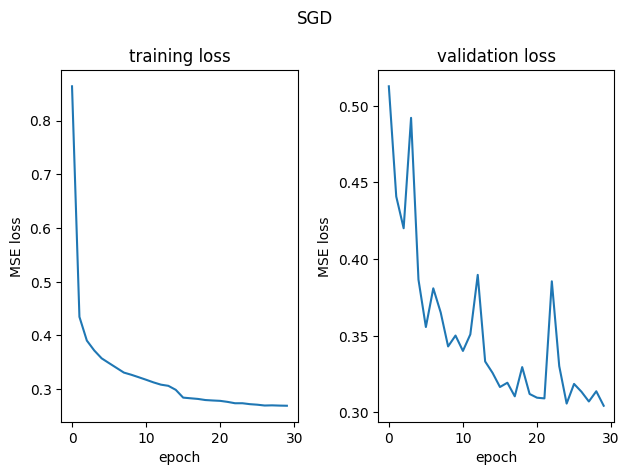

Optimizer: SGD with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8466793012895942
Validation loss for epoch: 0.5201)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.44172527349298507
Validation loss for epoch: 0.4382)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40285854877294164
Validation loss for epoch: 0.4168)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3841807324999729
Validation loss for epoch: 0.4263)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37041395479005523
Validation loss for epoch: 0.3983)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3464731268288024
Validation loss for epoch: 0.3639)

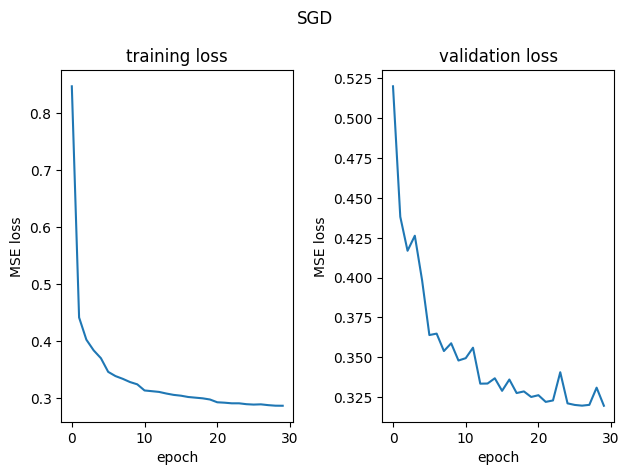

Optimizer: SGD with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7483249033710598
Validation loss for epoch: 0.4872)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.43993085906305146
Validation loss for epoch: 0.4397)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40822276827442433
Validation loss for epoch: 0.4366)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3842706112768007
Validation loss for epoch: 0.3958)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3728852652804514
Validation loss for epoch: 0.4177)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35714548234456933
Validation loss for epoch: 0

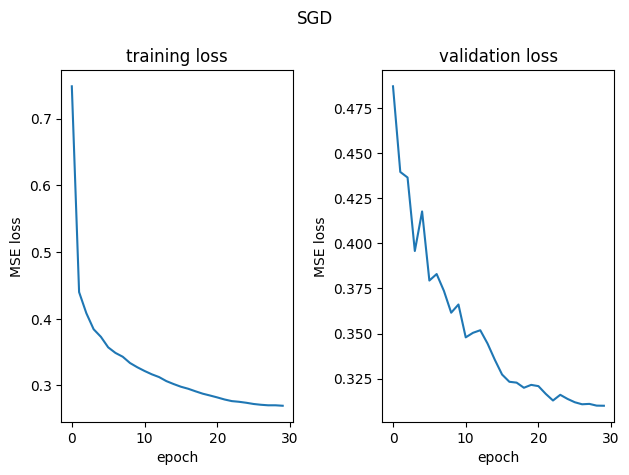

Optimizer: SGD with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8036971650687994
Validation loss for epoch: 0.5202)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.45832806230580386
Validation loss for epoch: 0.4785)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41017442311992686
Validation loss for epoch: 0.4255)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38597489575303234
Validation loss for epoch: 0.4045)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3665682798399862
Validation loss for epoch: 0.3916)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35662791245015324
Validation loss f

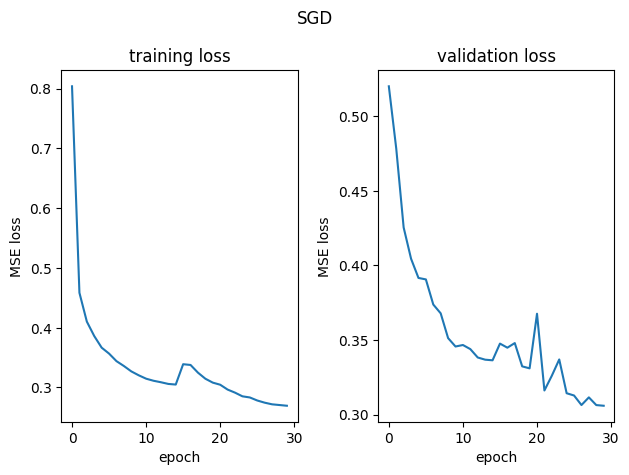

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6127469810302806
Validation loss for epoch: 0.4303)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4079137286253735
Validation loss for epoch: 0.4159)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37377106142848465
Validation loss for epoch: 0.3526)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3470182664263829
Validation loss for epoch: 0.3415)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3381549096377814
Validation loss for epoch: 0.3340)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31819865550944765
Validation loss for epoch:

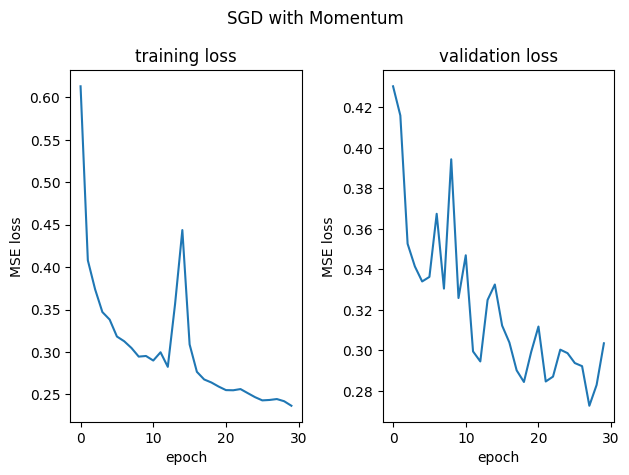

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6142213871059692
Validation loss for epoch: 0.4794)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4091691966539463
Validation loss for epoch: 0.3885)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.36573392451139153
Validation loss for epoch: 0.4153)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34273784996661466
Validation loss for epoch: 0.3464)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3334360412956603
Validation loss for epoch: 0.3374)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2928322403963688
Validation loss for e

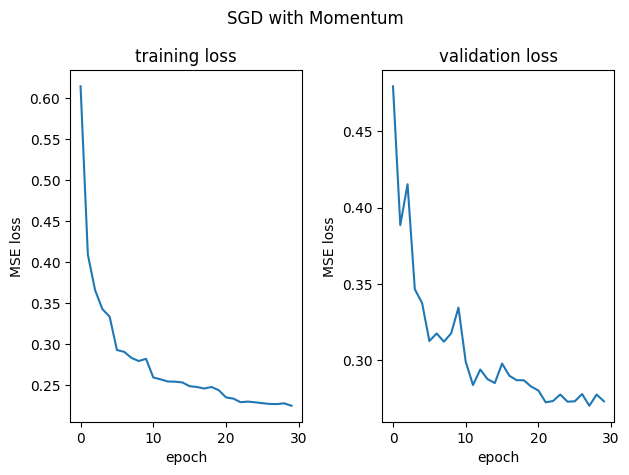

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5827122148686805
Validation loss for epoch: 0.4603)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39866458238885466
Validation loss for epoch: 0.4015)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37595963006657834
Validation loss for epoch: 0.3709)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3513421564140415
Validation loss for epoch: 0.3471)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3308480128283258
Validation loss for epoch: 0.3475)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3242733262446338
Validation loss

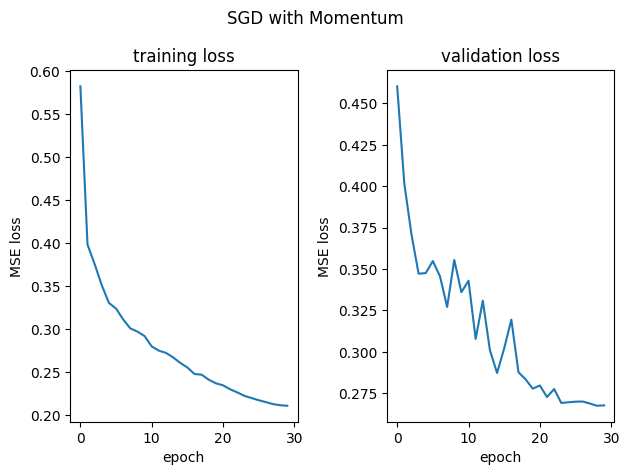

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.632600460432272
Validation loss for epoch: 0.6948)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.40558903333030444
Validation loss for epoch: 0.3715)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3650961234605154
Validation loss for epoch: 0.3806)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33541401891054307
Validation loss for epoch: 0.3500)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3171073987717386
Validation loss for epoch: 0.3440)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3103633781614821
Valida

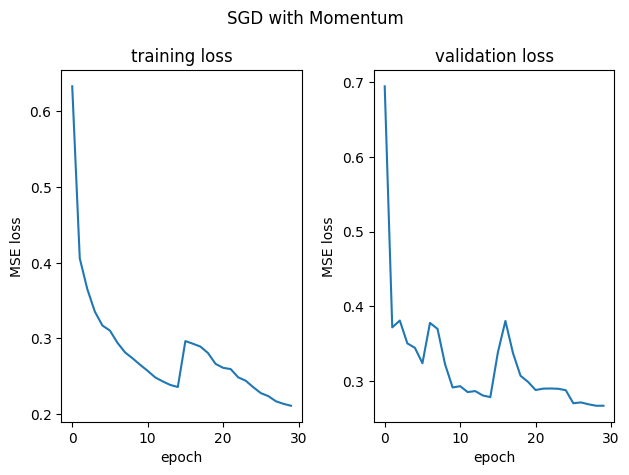

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5513827289100242
Validation loss for epoch: 0.4319)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37614577039416913
Validation loss for epoch: 0.3840)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3500215102283828
Validation loss for epoch: 0.4051)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33127271433451533
Validation loss for epoch: 0.3642)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3173240270234842
Validation loss for epoch: 0.3459)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3069025907764393
Validation loss f

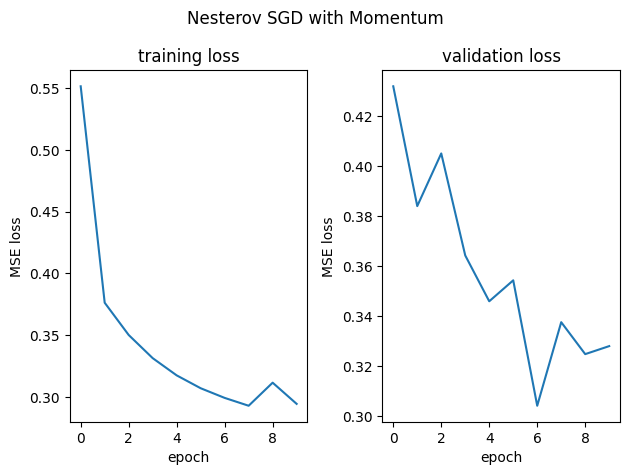

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5519734888246893
Validation loss for epoch: 0.4114)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37774470473219335
Validation loss for epoch: 0.3778)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3463999407646139
Validation loss for epoch: 0.3462)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3251250585030138
Validation loss for epoch: 0.3574)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31553017615085155
Validation loss for epoch: 0.3546)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29008564600242975
Validation 

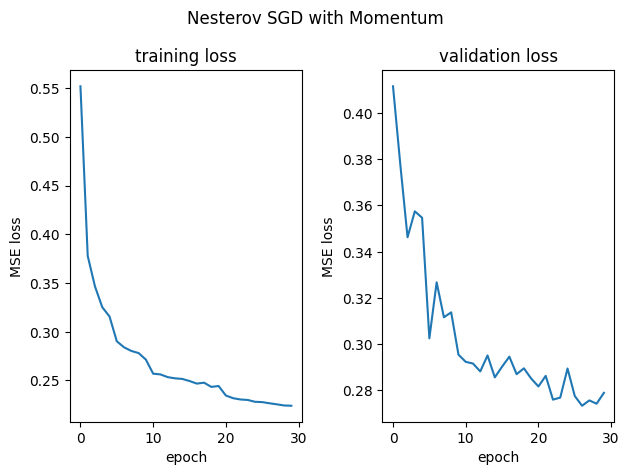

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5478423801209547
Validation loss for epoch: 0.4542)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38103982028180516
Validation loss for epoch: 0.3682)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3450593279295527
Validation loss for epoch: 0.3652)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3296886829214286
Validation loss for epoch: 0.3470)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3153590980290839
Validation loss for epoch: 0.3364)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.302584724912865
Validati

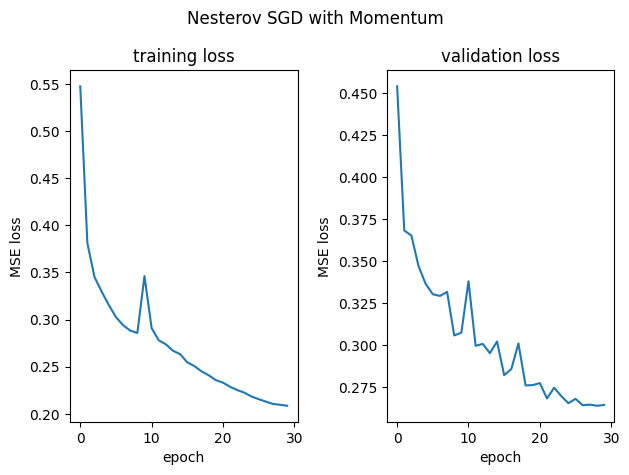

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5459479296629408
Validation loss for epoch: 0.6999)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3815746707264828
Validation loss for epoch: 0.3673)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3495029290824865
Validation loss for epoch: 0.3802)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3270332922219439
Validation loss for epoch: 0.3266)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3163744441802259
Validation loss for epoch: 0.3316)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.300709243319862

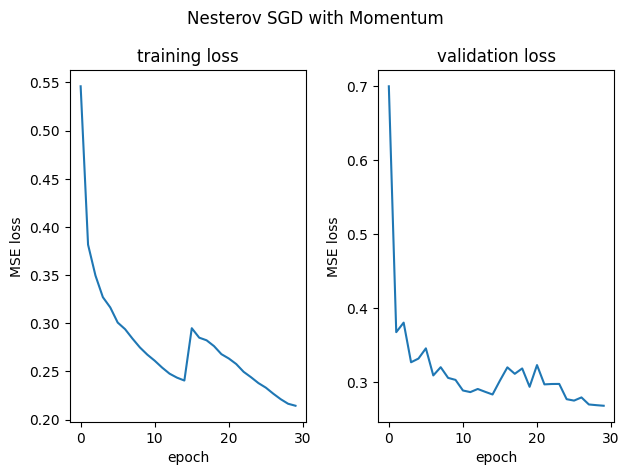

Optimizer: RMSProp with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 417.1036991967234
Validation loss for epoch: 0.4351)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.47286258837356504
Validation loss for epoch: 0.3846)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41784809140768725
Validation loss for epoch: 0.8608)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4553145320047583
Validation loss for epoch: 1.0507)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.38985928662319097
Validation loss for epoch: 0.3507)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.36423781573508696
Validation loss for epoch: 0.3389)


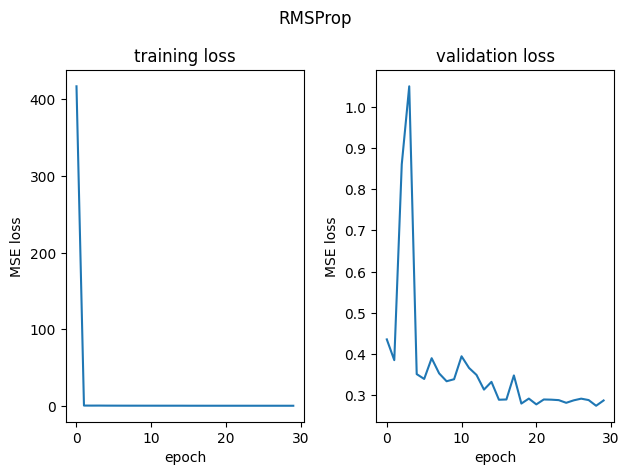

Optimizer: RMSProp with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 541.3052777280059
Validation loss for epoch: 0.4272)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4175121386131618
Validation loss for epoch: 0.3890)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.43096079703717105
Validation loss for epoch: 0.3973)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.41153887672498163
Validation loss for epoch: 0.3894)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3908292172493133
Validation loss for epoch: 0.3499)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.324725422233475
Validation loss for epoch: 0.3330

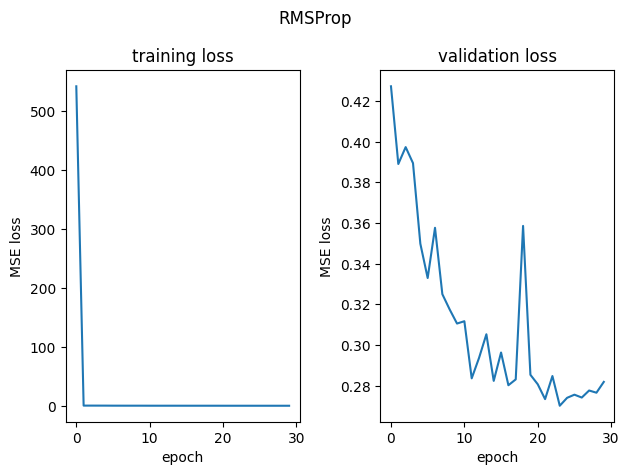

Optimizer: RMSProp with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1404.665159405234
Validation loss for epoch: 0.6106)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.44815332699665983
Validation loss for epoch: 0.4454)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.43794269993307844
Validation loss for epoch: 0.4791)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4567319436279018
Validation loss for epoch: 0.3996)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.47494550848758854
Validation loss for epoch: 0.3842)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.4890424001434472
Validation loss for epoch

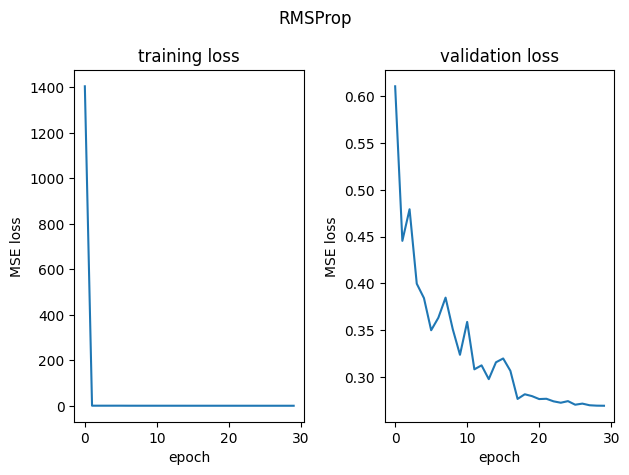

Optimizer: RMSProp with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1567.0072984570488
Validation loss for epoch: 0.5090)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.45341435785248746
Validation loss for epoch: 0.4155)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4543984931918372
Validation loss for epoch: 0.4547)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4106075739471522
Validation loss for epoch: 0.3835)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.39152040790799447
Validation loss for epoch: 0.5999)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3628400219357119
Validation loss

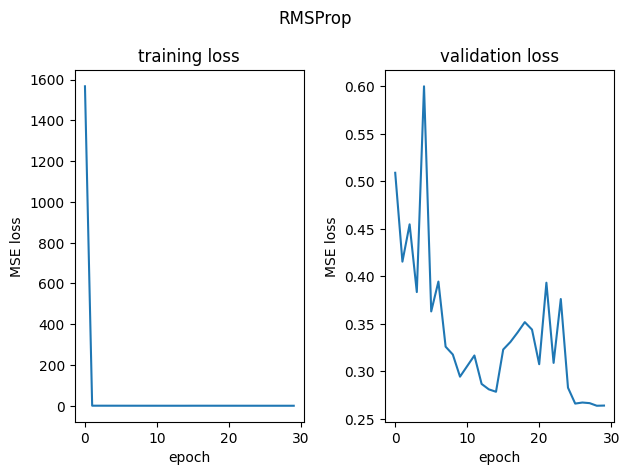

Optimizer: Adam with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5432221501801922
Validation loss for epoch: 0.4563)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37023988793051876
Validation loss for epoch: 0.3882)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.368092214837011
Validation loss for epoch: 0.3563)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34172845272495683
Validation loss for epoch: 0.3250)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3234523877633356
Validation loss for epoch: 0.3213)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3225252125082554
Validation loss for epoch: 0.3115)

----

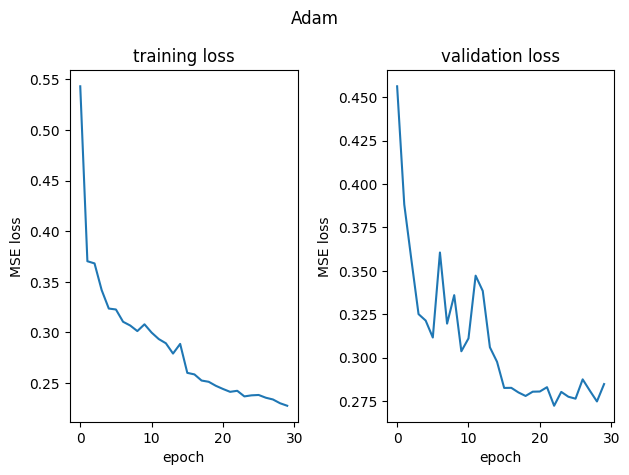

Optimizer: Adam with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5426462357451695
Validation loss for epoch: 0.4402)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3831214311540918
Validation loss for epoch: 0.3542)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.364495244173877
Validation loss for epoch: 0.5258)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33453667651763
Validation loss for epoch: 0.4655)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33820448463073877
Validation loss for epoch: 0.3291)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29828139460456055
Validation loss for epoch: 0.3055)

-

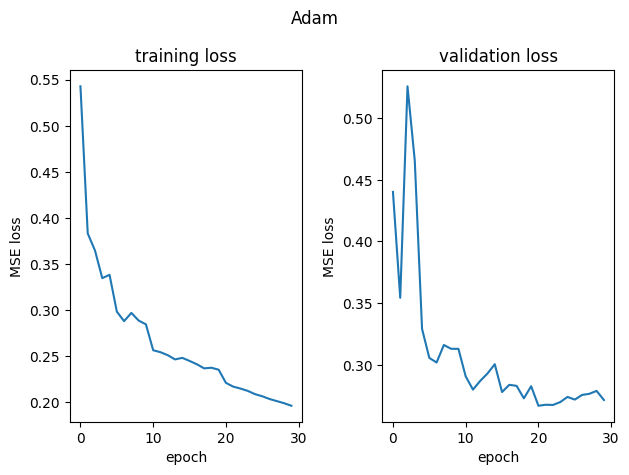

Optimizer: Adam with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.4801383386407279
Validation loss for epoch: 0.3829)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3821793752928487
Validation loss for epoch: 0.3922)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35754451836434614
Validation loss for epoch: 0.3791)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34314170115487236
Validation loss for epoch: 0.3607)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3432662831042456
Validation loss for epoch: 0.3437)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3216722739151621
Validation loss for epoch: 0

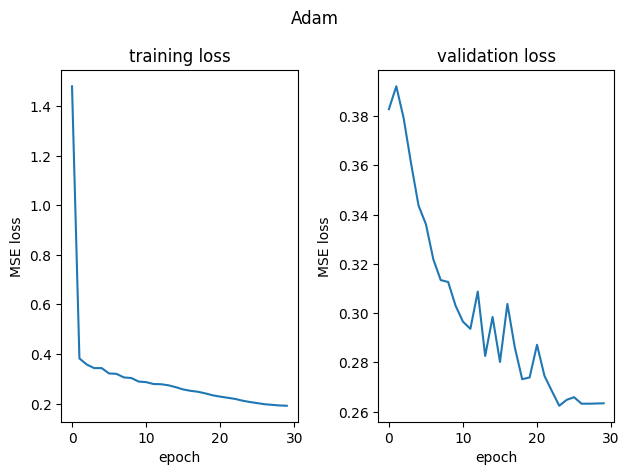

Optimizer: Adam with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5369126319522615
Validation loss for epoch: 0.3826)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39244031324257367
Validation loss for epoch: 0.3639)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.36480907751329705
Validation loss for epoch: 0.3801)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34689110196071915
Validation loss for epoch: 0.3412)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3216997675630635
Validation loss for epoch: 0.3196)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3104093298480838
Validation loss f

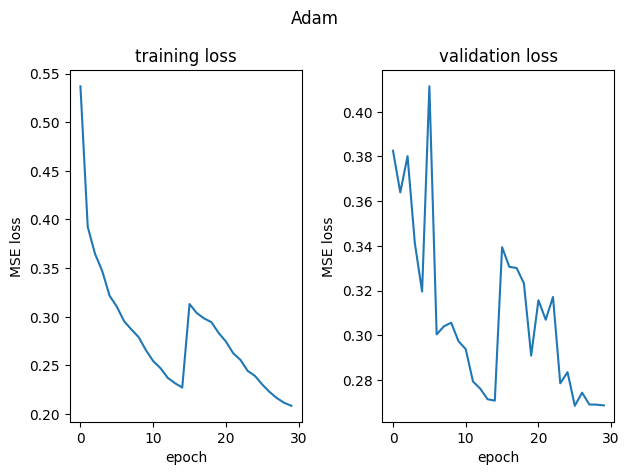

{'optimizer': 'Adam', 'scheduler': 'CosineAnnealingWarmRestarts', 'lr': 0.005, 'val_loss': np.float64(0.25918457542410983), 'train_loss': [np.float64(0.5279952893116041), np.float64(0.3736506601284563), np.float64(0.36858083495655947), np.float64(0.338631682130879), np.float64(0.32789919378680993), np.float64(0.30480485846313227), np.float64(0.29464212898989167), np.float64(0.286155372083319), np.float64(0.2753518024640801), np.float64(0.26593612641326886), np.float64(0.25738044684769307), np.float64(0.25092732359086517), np.float64(0.24607528367005618), np.float64(0.23750800491038676), np.float64(0.23429954797029495), np.float64(0.30664015599254485), np.float64(0.28479064035072793), np.float64(0.277810765001758), np.float64(0.28017998274119027), np.float64(0.26750905142553083), np.float64(0.25897582115984596), np.float64(0.2521116600693327), np.float64(0.2465335237010654), np.float64(0.25134444945549544), np.float64(0.22924671399580165), np.float64(0.22040854969713014), np.float64(0.2

In [ ]:
# best model: NeuralNet_deeper_wide, best epoch: 28, best validation loss: 0.2711376182792723
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
best_model = NeuralNet_deeper_wide()
torch.manual_seed(302); np.random.seed(302) # for safety reasons
lr_rates = [0.001,0.005,0.01]

best_combi = {
    'optimizer': None,
    'scheduler': None,
    'lr': None,
    'val_loss': 100,
    'train_loss': None,
    'epoch': None}

# todo is this enough variation? should we vary num_epochs?
# todo scheduler params need some rethinking and we should remove a scheduler and an optimizer to reduce compute time
schedulers = {
    'StepLR': lambda optimizer: StepLR(optimizer, step_size=15, gamma=0.5),
    'MultiStepLR': lambda optimizer: MultiStepLR(optimizer, milestones=[5, 10, 20], gamma=0.5),
    'CosineAnnealingLR': lambda optimizer: CosineAnnealingLR(optimizer, T_max=30),
    'CosineAnnealingWarmRestarts': lambda optimizer: CosineAnnealingWarmRestarts(optimizer, T_0=15),
}

for lr in lr_rates:
    optimizers = {
        'SGD': lambda params: torch.optim.SGD(params, lr=lr, momentum=0),
        'SGD with Momentum': lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9),
        'Nesterov SGD with Momentum': lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9, nesterov=True),
        'RMSProp': lambda params: torch.optim.RMSprop(params, lr=lr),
        'Adam': lambda params: torch.optim.Adam(params, lr=lr)
    }
    # optimizers = {
    #     'Adam': lambda params: torch.optim.Adam(params, lr=lr)
    # }

    for optimizer_name, optimizer_init_fn in optimizers.items():
        for scheduler_name, scheduler_init_fn in schedulers.items():
            model = best_model
            model.to(device)
            # reinstantiating should reset optimizer parameters
            optimizer = optimizer_init_fn(model.parameters())
            scheduler = scheduler_init_fn(optimizer)

            print(f'Optimizer: {optimizer_name} with learning rate: {lr} and scheduler: {scheduler_name} \n')
            train_loss, val_loss = train_model(model, train_loader, val_loader, device, optimizer=optimizer, num_epochs=30, scheduler=scheduler)
            # val_accuracies_per_optimizer[optimizer_name] = val_accuracies[-1] # save the last accuracy
            print('-'*50)

            # save the best combination for the lowest validation loss, used later then
            if np.min(val_loss) < best_combi['val_loss']:
                best_combi['val_loss'] = np.min(val_loss)
                best_combi['train_loss'] = np.min(train_loss)
                best_combi['optimizer'] = optimizer_name
                best_combi['scheduler'] = scheduler_name
                best_combi['lr'] = lr
                best_combi['epoch'] = np.argmin(val_loss)

            fig,axs = plt.subplots(1,2,layout="tight")
            axs[0].plot(train_loss)
            axs[0].set_title("training loss")
            axs[0].set_xlabel("epoch")
            axs[0].set_ylabel("MSE loss")

            axs[1].plot(val_loss)
            axs[1].set_title("validation loss")
            axs[1].set_xlabel("epoch")
            axs[1].set_ylabel("MSE loss")
            plt.suptitle(f"{optimizer_name}")
            plt.show()
            # reset model and optimizer https://www.youtube.com/watch?v=r9tOQ6EKS1Y&ab_channel=deeplizard
            for layer in model.children():
                layer.reset_parameters()

print(best_combi)


## d) Final Training with best parameters

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6296279614609954
-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.35905990314430897
-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3459679981644175
-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.32411273510846417
-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3384807375680029
-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2962104968396963
-------------------- Epoch 6 --------------------
Average Training Loss for epoch(over all batches) 0.28591961187467113
-------------------- Epoch 7 --------------------
Average Training Loss for epoch(over all batches) 0.27648462525247475
-------------------- Epoch 8 ---------------

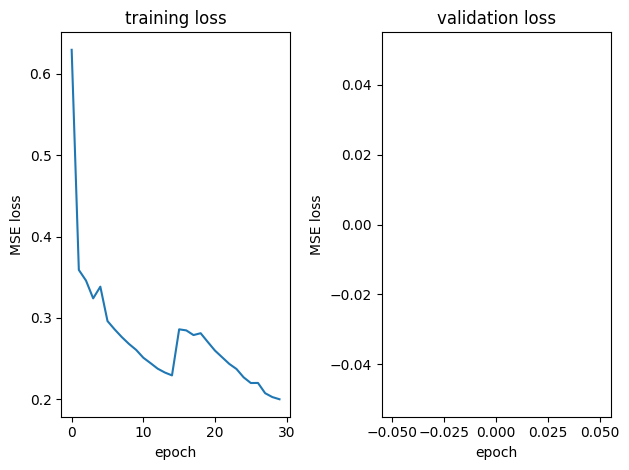

In [ ]:
final_training_model = NeuralNet_deeper_wide()
final_X_train = torch.concatenate((X_train_torch, X_validation_torch))
final_y_train = torch.concatenate((y_train_torch, y_validation_torch))
final_train_dataset = TensorDataset(final_X_train,final_y_train)
final_train_loader = DataLoader(final_train_dataset, batch_size=32, shuffle=True)

lr = 0.005
# final_X_train.to(device)
# final_y_train.to(device)

final_optimizer = torch.optim.Adam(final_training_model.parameters(), lr=lr)
final_scheduler = CosineAnnealingWarmRestarts(final_optimizer, T_0=15)


train_loss, val_loss = train_model(final_training_model, final_train_loader, device=device, optimizer=final_optimizer, num_epochs=30, scheduler=final_scheduler)
# val_accuracies_per_optimizer[optimizer_name] = val_accuracies[-1] # save the last accuracy
print('-'*50)

# save the best combination for the lowest validation loss, used later then

fig,axs = plt.subplots(1,1,layout="tight")
axs[0].plot(train_loss)
axs[0].set_title("training loss")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("MSE loss")
plt.show()




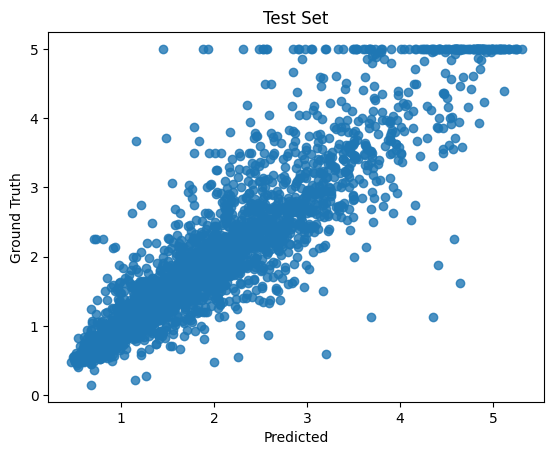

tensor(0.2565, device='cuda:0')


In [ ]:
# Test
final_training_model.to(device) # Set model to gpu
final_training_model.eval()
X_test_torch = X_test_torch.to(device)
y_test_torch = y_test_torch.to(device)
loss_fn = nn.MSELoss()
# Run forward pass
with torch.no_grad():
  pred = final_training_model(X_test_torch)
loss = loss_fn(y_test_torch, pred)


plt.scatter(pred.cpu(), y_test_torch.cpu(), alpha=0.8)
plt.ylabel("Ground Truth")
plt.xlabel("Predicted")
plt.title("Test Set")
plt.show()
print(loss)

## f) Binary Classification

In [7]:
from models import NeuralNet_deeper_wide_classification

#combine training data back together with validation data
X_train_norm = normalized_sets[0]
X_val_norm = normalized_sets[1]
X_test_norm = normalized_sets[2]

X_train_recombined = np.concatenate((X_train_norm, X_val_norm), axis=0)
y_train_recombined = np.concatenate((y_train, y_validation),axis=0)

y_train_recombined[y_train_recombined < 2], y_test[y_test < 2] = 0, 0
y_train_recombined[y_train_recombined >= 2], y_test[y_test >= 2] = 1, 1

##########################################################


X_train_torch = torch.tensor(X_train_recombined,dtype=torch.float32)
y_train_torch = torch.tensor(y_train_recombined.reshape((len(y_train_recombined),1)),dtype=torch.float32)
X_test_torch = torch.tensor(X_test_norm,dtype=torch.float32)
y_test_torch = torch.tensor(y_test.reshape((len(y_test),1)),dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_torch,y_train_torch)
test_dataset = torch.utils.data.TensorDataset(X_test_torch,y_test_torch)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
#########################################################

loss_fn = nn.NLLLoss()


#Create the full model(NN, optimizer, scheduler), depending on what performed best
best_learning_rate = 0.005
best_num_epochs = 10 #TODO: noch anpassen
best_model = NeuralNet_deeper_wide_classification().to(device)
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=best_learning_rate)

avg_training_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1,best_num_epochs+1):# one loop over the dataset = 1 epoch
    print('-'*20, f'Epoch {epoch}', '-'*20)
    # Train one epoch
    best_model.train() #> setting model to "train mode", because some layers act different in training or evaluation
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.float()
        target = target.float()

        best_optimizer.zero_grad()#needed, because otherwise the new gradients would get summed onto the old ones
        # the sum would be useful e.g. for CNNs

        log_probs = best_model(data)# log probabilities of batch
        target = torch.squeeze(target.long())
        print(target)
        loss = loss_fn(log_probs, target)
        loss.backward()
        best_optimizer.step()

        losses.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Train Epoch {epoch} | Loss: {loss.item()}')
    
    avg_train_loss = np.mean(losses[-len(train_loader):])
    print(f'\nAverage train loss in epoch {epoch}: {avg_train_loss}')
    
    # Evaluate on test set
    best_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.float()
            target = target.float()

            log_probs = best_model(data)
            target = torch.squeeze(target.long())
            
            test_loss += F.nll_loss(log_probs, target, reduction='sum').item()  # sum up batch loss
            pred = torch.argmax(log_probs, dim=1)  # get the index of the max log-probability
            correct += (pred == target).sum().item()

    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)

    test_losses.append(test_loss)
    test_accuracies.append(avg_correct)

    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * avg_correct:.0f}%)\n')


-------------------- Epoch 1 --------------------
tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0])


IndexError: Target 1 is out of bounds.

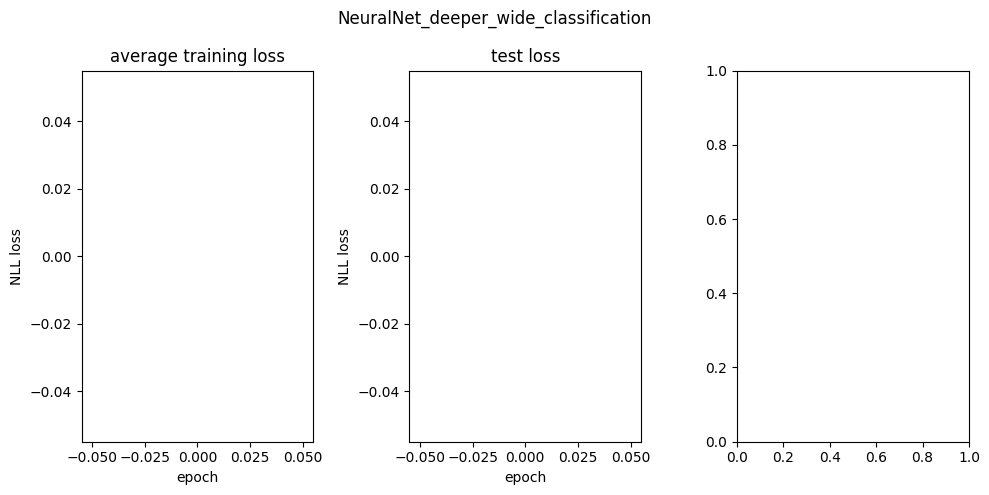

<Figure size 640x480 with 0 Axes>

In [8]:
fig1,axs = plt.subplots(1,3,layout="tight",figsize = (10,5))
axs[0].plot(np.linspace(1,len(test_losses),len(test_losses)),avg_training_losses)
axs[0].set_title("average training loss")
# axs[0].set_ylim([max(train_loss),max(train_loss)])
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("NLL loss")

axs[1].plot(np.linspace(1,len(test_losses),len(test_losses)),test_losses)
axs[1].set_title("test loss")
# axs[1].set_ylim([max(val_loss),max(val_loss)])
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("NLL loss")
plt.suptitle(f"{best_model._get_name()}")
plt.show()

axs[2].plot(np.linspace(1,len(test_accuracies),len(test_accuracies)), test_accuracies)
axs[2].set_title("test accuracy")
# axs[1].set_ylim([max(val_loss),max(val_loss)])
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("accuracy in %")
plt.suptitle(f"{best_model._get_name()}")
plt.show()